---
layout: default
title: "Deep Learning - Speed up learning - Normalization"
categories: deeplearning
permalink: /ML28/
order: 28
comments: true
---

In [2]:
%pylab --no-import-all inline
from plot_ann import ann
from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


# Training set normalization
Training set normalization is a technique that speeds up the learning process. Typically, input features come in range that differ of some order of magnitude. One feature might come in range $[0, 1000]$ and another in range $[0, 1]$. 

Difference in the scale of input features might make training very slow and for this reason input features are usually normalized. In <a href="#fig:meannorm">the figure below</a> the effect of the two steps of **mean normalization** are shown.

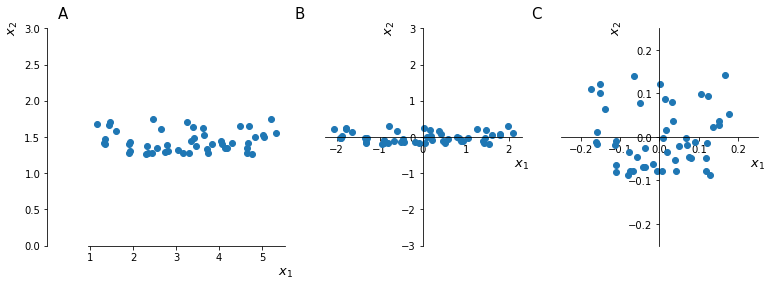

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

x = np.linspace(1, 5)+np.random.rand(50)*.5
y = ((np.random.rand(50)-.5 ) *.5)+1.5

axes[0].plot(x, y, ls='none', marker='o')
axes[0].set_ylim(0, 3)

# x -= x.mean()
# y -= y.mean()
axes[1].plot(x-x.mean(), y-y.mean(), ls='none', marker='o')
axes[1].set_ylim(-3, 3)

axes[2].plot((x-x.mean())/(x**2).mean(), (y-y.mean())/(y**2).mean(), ls='none', marker='o')
axes[2].set_ylim(-.25, .25)
axes[2].set_xlim(-.25, .25)

for ax, l in zip(axes, 'ABC'):
#     ax.set_aspect('equal')
    ax.text(-0.1, 1.1, l, transform=ax.transAxes,
      fontsize=15, va='top', ha='right')
    ax.set_xlabel('$x_1$', x=1, fontsize=13)
    ax.set_ylabel('$x_2$', y=1, fontsize=13)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

<i id="fig:meannorm">mean normalization effect on feature space $X \in \mathbb{R}^{2}$. Raw feature space (A); $X - \mu$ (B); $\frac{X}{\sigma^2}$ (C)</i>.

To intuitively understand why mean normalization speeds up training the values, <a href="#fig:costnorm">figure below</a> shown a simplified view of how the space of the values assumed by the cost function $J$ change with un-normalized (panels A,C) and normalized inputs (panels B,D)

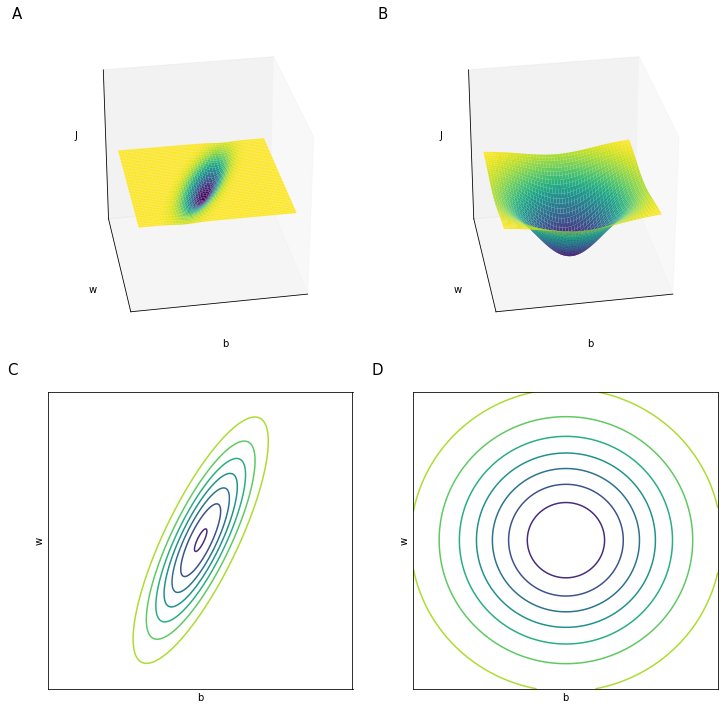

In [4]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[.2, .05], [.3, .7]])
ax1.plot_surface(x, y, -rv.pdf(pos), cmap='viridis')
ax3.contour(x, y, -rv.pdf(pos))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1.0, 2], [0, 1]])
ax2.plot_surface(x, y, -rv.pdf(pos)*20, cmap='viridis')
ax4.contour(x, y, -rv.pdf(pos))

for i, (ax, l) in enumerate(zip([ax1, ax2, ax3, ax4], 'ABCD')):
    if i < 2:
        ax.text2D(-0.1, 1.1, l, transform=ax.transAxes,
          fontsize=15, va='top', ha='right')
        ax.set_zlim(-np.pi, np.pi)
        ax.set_box_aspect([1,1,1])
        ax.view_init(30, 80)
        ax.set_zticks([])
        ax.set_zlabel('J');    
    else:
        ax.text(-0.1, 1.1, l, transform=ax.transAxes,
          fontsize=15, va='top', ha='right')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('b')
    ax.set_ylabel('w')

<i id="fig:costnorm">Representative shape of $J$ for un-normalized (A, C) and normalized (B, D) feature space</i>

## Vanishing or Exploding gradients
Under some circumstances it may happen, especially in very deep neural networks, that gradients (derivatives) assume very small (vanishing) or big (exploding) values.

This problem can be drastically reduced through a careful choice of the random weight initialization.

Suppose we have a very deep network as in the <a href="#fig:superdeep">figure below</a>. This network has many hidden layers and consequently a series of parameters matrices $(w^{[1]}, w^{[2]}, \dots w^{[L]})$. For the sake of simplicity let's say that this network has linear activation function ($g(z) = z$) and that $b^{[l]}=0$

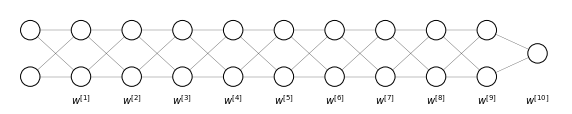

In [5]:
fig, ax = plt.subplots(figsize=(10, 2))
architecture = [2]*10+[1]
ann(architecture, ax=ax, width=6, radius=2, layer_labels=['']+[f'$w^{{[{i}]}}$' for i in range(1, len(architecture))]);
ax.set_aspect('equal')

<i id="fig:superdeep">A very deep neural network that can suffer from either exploding or vanishing gradients depending on the values of $w^{[l]}$</i>

For this network

$$
\begin{aligned}
\hat{y} = w^{[L]} \cdot w^{[L-1]} \cdot w^{[L-2]} \cdot \ldots \cdot w^{[2]} \cdot  w^{[1]} \cdot x \\
z^{[1]} = w^{[1]}x \\
a^{[1]} = g(z^{[1]}) = z^{[1]} \\
a^{[2]}  =  g(z^{[2]}) =  g(w^{[2]}a^{[1]}) \\
a^{[2]}  =  g(z^{[2]}) =  g(w^{[2]}w^{[1]}x) \\
\cdots
\end{aligned}
$$

Suppose that each of our weight matrices $w^{[l]}$ is

$$
w^{[l]} = 
\begin{bmatrix}
1.5 & 0 \\
0 & 1.5
\end{bmatrix}
\qquad \to \qquad 
\hat{y}=
\begin{bmatrix}
1.5 & 0 \\
0 & 1.5
\end{bmatrix}^{L-1}x
$$

$\hat{y}$ will increase exponentially with $1.5^L$. This implies that for large values of $L$ the value of $\hat{y}$ will explode. Conversely the value of $\hat{y}$ will vanish for weights $w^{[l]} < I$ (where $I$ is the identity matrix). 

In general 

$$
\hat{y} 
\begin{cases}
w^{[l]} > I \qquad \to \text{explode} \\ 
w^{[l]} < I \qquad \to \text{vanish}
\end{cases}
$$

And while we made this argument for the activation values we can make a similar argument for the gradients

## Correct weight initialization to attenuate gradient derive

Let's focus on a single neuron with 4 input features

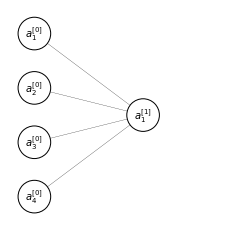

In [6]:
ax, *_ = ann([4, 1], node_labels=True, radius=2)
ax.set_aspect('equal')

<i id="fig:onelayernn">A single layer neural network with 4 input features</i>

For the network in <a href="#fig:onelayernn">the figure above</a>

$$
z = w_1x_1 + w_2x_2 + \ldots + w_nx_n
$$

So the larger $n$ is, the smaller we want to set $w_i$ in order to prevent gradient explosion. It would be ideal to set the variance of $w_i$ to be inversely proportional to $n$

$$
\sigma^2(w_i) = \frac{1}{n}
$$

So, in order to set the variance for random variables **drawn from a Gaussian distribution** we would write our weights matrix as:

In [7]:
nx = 4
np.random.randn(1, nx)*np.sqrt(1/nx)

array([[-0.13061448, -0.59629756,  0.59564903, -0.53558851]])

where [`randn()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html) draws from a Gaussian distribution and the term can vary depending on the activation function used and implementation details:

For a ReLU activation function:

$$
\sqrt{\frac{2}{n^{[l-1]}}}
$$

For $\tanh$

$$
\sqrt{\frac{1}{n^{[l-1]}}}
$$

Or sometimes this different implementation, also called Xavier initialization:

$$
\sqrt{\frac{2}{n^{[l-1]}+1}}
$$